<a href="https://colab.research.google.com/github/Awaish0419/MultiPeriodBinomialTreePricing/blob/main/MultiPeriodBinomialTreePricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial parameters and import some necessary libraries.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

S0 = 100
r = 0.02
T = 1.5
sigma = 0.2
N = 6
K = 102
option_type = "call"
num_samples = 10000
seed = 66

# Binomial Tree Option Value

## Binomial Tree Option Class

In [4]:
class BinomialTreeOption:
  def __init__(self, S0, r, T, sigma, N, K, option_type="call"):
    self.S0 = S0  # Spot price
    self.r = r  # Risk-free rate
    self.T = T  # Maturity
    self.sigma = sigma  # Volatility
    self.N = N  # Number of steps
    self.K = K  # Strike price
    self.option_type = option_type.lower()  # 'call' or 'put'
    self.dt = T / N  # Time step
    self.u = np.exp(sigma * np.sqrt(self.dt))  # Up factor
    self.d = 1 / self.u  # Down factor
    self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)  # Risk-neutral probability

  def generate_price_tree(self):
    tree = np.zeros((self.N + 1, self.N + 1))
    tree[0, 0] = self.S0
    for i in range(1, self.N + 1):
      tree[0, i] = tree[0, i - 1] * self.u
      for j in range(1, i + 1):
        tree[j, i] = tree[j - 1, i - 1] * self.d
    return tree

  def price_option(self):
    # Generate the price tree
    tree = self.generate_price_tree()

    # Initialize option value at maturity
    option_values = np.zeros(self.N + 1)
    if self.option_type == "call":
      option_values = np.maximum(0, tree[:, self.N] - self.K)
    elif self.option_type == "put":
      option_values = np.maximum(0, self.K - tree[:, self.N])

    # Backward induction to calculate option price
    for i in range(self.N - 1, -1, -1):
      for j in range(i + 1):
        option_values[j] = np.exp(-self.r * self.dt) * (self.p * option_values[j] + (1 - self.p) * option_values[j + 1])

    return option_values[0]

  def price_options(self, spot_prices):
    option_values = []
    initial_S0 = self.S0
    for price in spot_prices:
      self.S0 = price
      option_values.append(self.price_option())
    self.S0 = initial_S0
    return option_values

  def change_type(self):
    if (self.option_type == "call"):
      self.option_type = "put"
    else:
      self.option_type = "call"

  def plot_option_price_vs_spot(self, spot_prices):
    prices = []
    for S in spot_prices:
      self.S0 = S
      prices.append(self.price_option())

    plt.plot(spot_prices, prices, label=f"{self.option_type.capitalize()} Option Price")

    self.change_type()
    prices = []
    for S in spot_prices:
      self.S0 = S
      prices.append(self.price_option())

    plt.plot(spot_prices, prices, label=f"{self.option_type.capitalize()} Option Price")

    plt.xlabel("Spot Price")
    plt.ylabel("Option Price")
    plt.title(f"{self.option_type.capitalize()} Option Price vs Spot Price")
    plt.legend()

  def plot_delta_vs_spot(self, spot_prices, dS=1e-4):
    deltas = []
    for S in spot_prices:
      # Calculate option price for S and S + dS
      self.S0 = S
      price_1 = self.price_option()
      self.S0 = S + dS
      price_2 = self.price_option()

      # Estimate Delta using finite difference
      delta = (price_2 - price_1) / dS
      deltas.append(delta)

    plt.plot(spot_prices, deltas, label=f"{self.option_type.capitalize()} Option Delta")

    self.change_type()

    deltas = []
    for S in spot_prices:
      # Calculate option price for S and S + dS
      self.S0 = S
      price_1 = self.price_option()
      self.S0 = S + dS
      price_2 = self.price_option()

      # Estimate Delta using finite difference
      delta = (price_2 - price_1) / dS
      deltas.append(delta)

    plt.plot(spot_prices, deltas, label=f"{self.option_type.capitalize()} Option Delta")

    plt.xlabel("Spot Price")
    plt.ylabel("Delta (∂V/∂S)")
    plt.title(f"{self.option_type.capitalize()} Option Delta vs Spot Price")
    plt.legend()
    plt.show()

  def print_delta_beta_tree(self):
    stock_tree = self.generate_price_tree()
    option_tree = np.zeros((self.N + 1, self.N + 1))
    for i in range(self.N + 1):
      if (self.option_type == "call"):
        option_tree[i, self.N] = np.maximum(0, stock_tree[i, self.N] - self.K)
      else:
        option_tree[i, self.N] = np.maximum(0, self.K - stock_tree[i, self.N])
    delta_tree = np.zeros((self.N, self.N))
    beta_tree = np.zeros((self.N, self.N))
    for i in range(self.N - 1, -1, -1):
      for j in range(i + 1):
        option_tree[j, i] = (self.p * option_tree[j, i + 1] + (1 - self.p) * option_tree[j + 1, i + 1]) / np.exp(self.r * self.dt)
        delta_tree[j, i] = (option_tree[j, i + 1] - option_tree[j + 1, i + 1]) / (stock_tree[j + 1, i] - stock_tree[j + 1, i + 1])
        beta_tree[j, i] = (option_tree[j, i] - delta_tree[j, i] * stock_tree[j, i]) / np.exp(self.r * self.dt)

    print(f"{self.option_type} Delta tree:")
    print(delta_tree)

    print(f"{self.option_type} Beta tree:")
    print(beta_tree)

  def print_both_delta_beta_tree(self):
    self.print_delta_beta_tree()
    self.change_type()
    self.print_delta_beta_tree()

  def combination(self, N, i):
    if i == 0 or i == N:
      return 1
    result = 1
    for k in range(1, i + 1):
      result = result * (N - k + 1) // k
    return result

  def plot_ST_distribution(self):
    final_prices = []
    probabilities = []
    for i in range(self.N + 1):
      ST = S0 * (self.u ** i) * (self.d ** (self.N - i))
      P = self.combination(self.N, i) * (self.p ** i) * ((1 - self.p) ** (self.N - i))
      final_prices.append(ST)
      probabilities.append(P)
    plt.plot(final_prices, probabilities)
    plt.title("Probability Distribution of S(T) from Binomial Tree")
    plt.xlabel("S(T)")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()

  def plot_log_ST_distribution(self):
    final_prices = []
    probabilities = []
    for i in range(self.N + 1):
      ST = S0 * (self.u ** i) * (self.d ** (self.N - i))

      P = self.combination(self.N, i) * (self.p ** i) * ((1 - self.p) ** (self.N - i))
      final_prices.append(np.log(ST))
      probabilities.append(P)
    plt.plot(final_prices, probabilities)
    plt.title("Probability Distribution of log(S(T)) from Binomial Tree")
    plt.xlabel("log(S(T))")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()

BTO = BinomialTreeOption(S0, r, T, sigma, N, K, option_type)

## Plot the price function V (S) with different values of spot price, for both call and puts, what you observe?

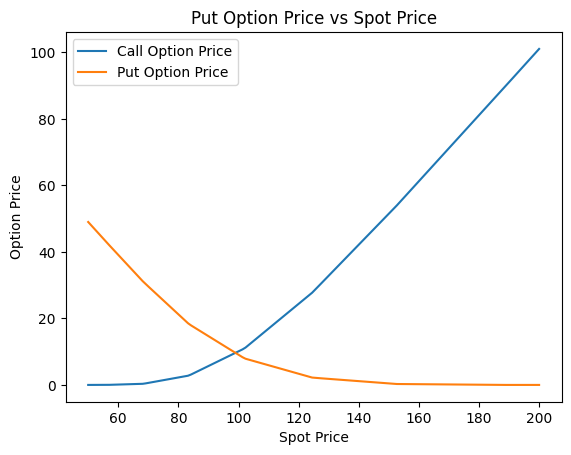

In [5]:
spot_prices = np.linspace(50, 200, 150)

BTO.plot_option_price_vs_spot(spot_prices)

# reset
BTO = BinomialTreeOption(S0, r, T, sigma, N, K, option_type)

According to the plots of prices of call options and put options, we can see that the call option value increases as the spot price increases, and the put option value decreases as the spot price increases. Additionally, the option price can never drop below 0.

## Plot the price function V (S) with different values of spot price, for both call and puts, what you observe?

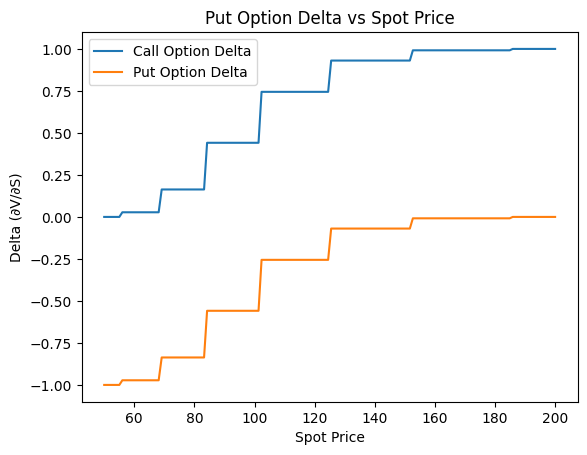

In [6]:
BTO.plot_delta_vs_spot(spot_prices)

# reset
BTO = BinomialTreeOption(S0, r, T, sigma, N, K, option_type)

## Can you obtain the replication portfolio for each node? (i.e. given a tree node, what is your ∆ and β)?

In [7]:
BTO.print_both_delta_beta_tree()

# reset
BTO = BinomialTreeOption(S0, r, T, sigma, N, K, option_type)

call Delta tree:
[[-0.12453184 -1.68710998 -2.04414339 -2.28399134 -2.32657368 -2.32657368]
 [ 0.         -0.08053214 -1.25095564 -1.75114359 -2.23197248 -2.32657368]
 [ 0.          0.         -0.03348559 -0.6399228  -1.16375991 -2.11640704]
 [ 0.          0.          0.         -0.         -0.         -0.        ]
 [ 0.          0.          0.          0.         -0.         -0.        ]
 [ 0.          0.          0.          0.          0.         -0.        ]]
call Beta tree:
[[ 22.43330641 201.22259823 272.19051868 341.34625637 393.30991965
  444.73874275]
 [  0.          11.73665479 132.26027408 205.75219524 292.79622182
  345.81579582]
 [  0.           0.           3.95599258  60.08212039 120.75649679
  242.70334371]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
put Delta tree:
[[ 0.09687092  0.6394637 

## At your final time state T = Tn, plot the distribution of S(T), can you identify it? (Hint: you can look at distribution of log(S(T)))

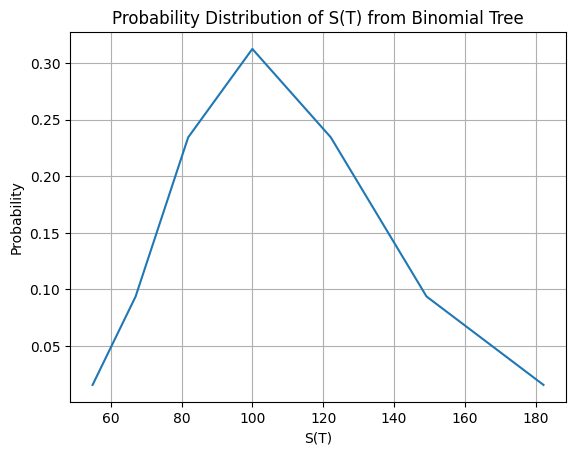

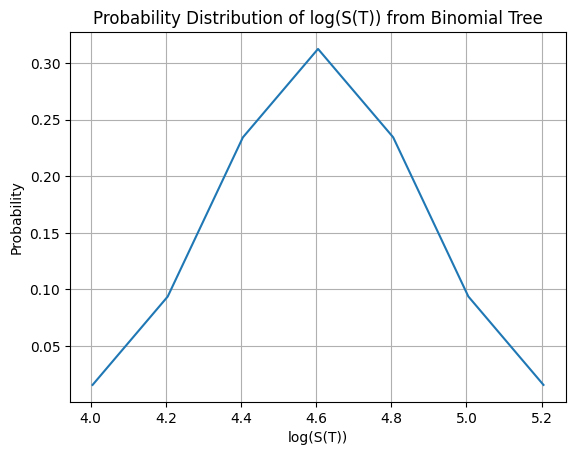

In [8]:
BTO.plot_ST_distribution()
BTO.plot_log_ST_distribution()

According to the plots, I can see that the distribution of S(T) follows a bias gaussian distribution, and the log(S(T)) follows a gaussian distribution.

## Can you modify your code so that it can price an american option?

In [9]:
class BinomialTreeAmericanOption:
  def __init__(self, S0, r, T, sigma, N, K, option_type="call"):
    self.S0 = S0  # Spot price
    self.r = r  # Risk-free rate
    self.T = T  # Maturity
    self.sigma = sigma  # Volatility
    self.N = N  # Number of steps
    self.K = K  # Strike price
    self.option_type = option_type.lower()  # 'call' or 'put'
    self.dt = T / N  # Time step
    self.u = np.exp(sigma * np.sqrt(self.dt))  # Up factor
    self.d = 1 / self.u  # Down factor
    self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)  # Risk-neutral probability

  def generate_price_tree(self):
    tree = np.zeros((self.N + 1, self.N + 1))
    tree[0, 0] = self.S0
    for i in range(1, self.N + 1):
      tree[0, i] = tree[0, i - 1] * self.u
      for j in range(1, i + 1):
        tree[j, i] = tree[j - 1, i - 1] * self.d
    return tree

  def price_option(self):
    # Generate the price tree
    tree = self.generate_price_tree()

    # Initialize option value at maturity
    option_values = np.zeros(self.N + 1)
    if self.option_type == "call":
      option_values = np.maximum(0, tree[:, self.N] - self.K)
    elif self.option_type == "put":
      option_values = np.maximum(0, self.K - tree[:, self.N])

    # Backward induction to calculate option price
    for i in range(self.N - 1, -1, -1):
      for j in range(i + 1):
        option_value = np.exp(-self.r * self.dt) * (self.p * option_values[j] + (1 - self.p) * option_values[j + 1])
        if option_value > (tree[j, i] - self.K):
          option_values[j] = option_value
        else:
          option_values[j] = tree[j, i] - self.K

    return option_values[0]

# Black-Scholes

## Plot the distribution of S(T), what you observe? What is the distribution of log(S(T))?

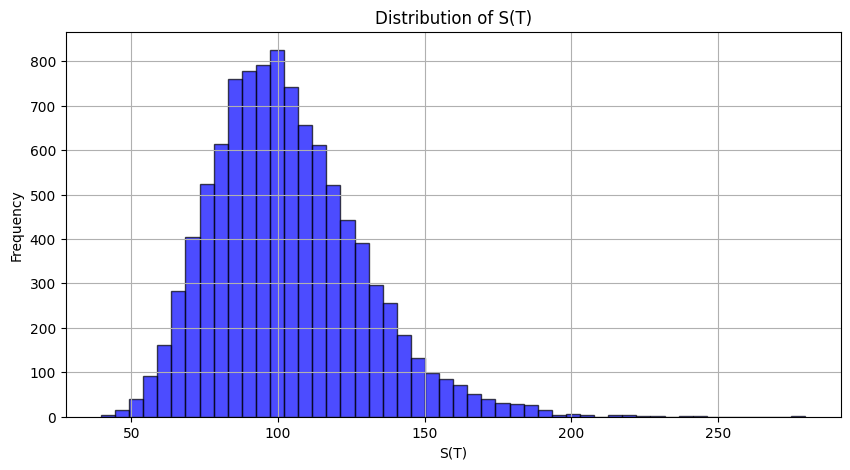

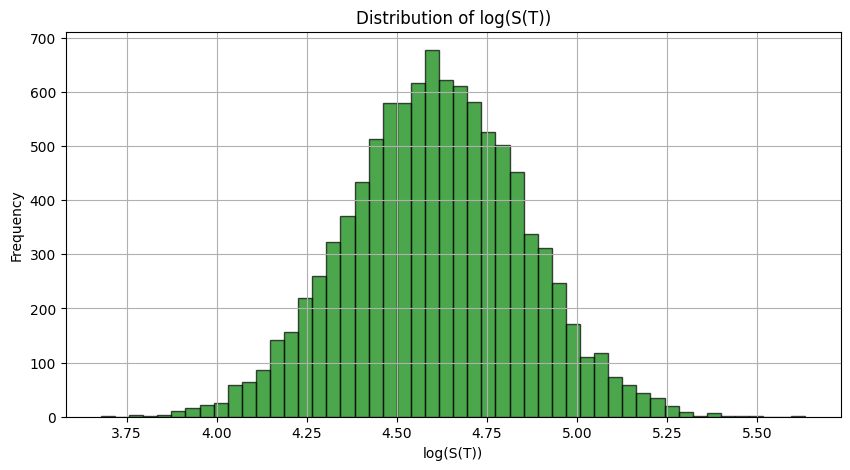

In [10]:
Z = np.random.normal(0, 1, num_samples)

ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

plt.figure(figsize=(10, 5))
plt.hist(ST, bins=50, alpha=0.7, color='b', edgecolor='k')
plt.xlabel('S(T)')
plt.ylabel('Frequency')
plt.title('Distribution of S(T)')
plt.grid(True)
plt.show()

log_ST = np.log(ST)

plt.figure(figsize=(10, 5))
plt.hist(log_ST, bins=50, alpha=0.7, color='g', edgecolor='k')
plt.xlabel('log(S(T))')
plt.ylabel('Frequency')
plt.title('Distribution of log(S(T))')
plt.grid(True)
plt.show()

According to the plots, we can see that the log(S(T)) follows a gaussian distribution.And the S(T) follows a bias gaussian distribution.

## Implement your formula form black-scholes in Python, and calculate the following:
 a) ∂V
 ∂S ≈ V(S+dS)−V(S)
 dS

 b) ∂V
 ∂σ ≈ V(σ+dσ)−V(σ)
 dσ
 where dS is your choice of bump size
 where dσ is your choice of bump size

 Plot a) and b) against different spot price S0, what you observe?

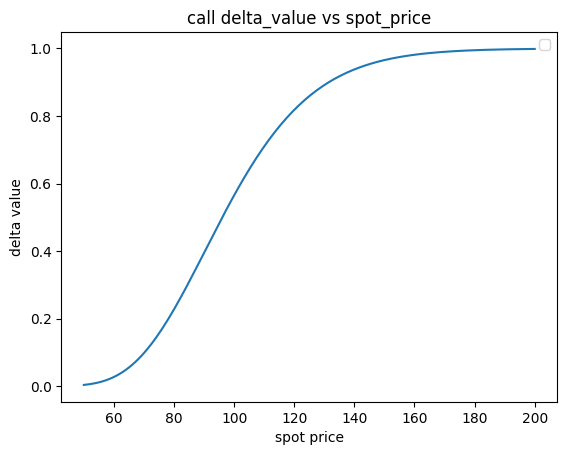

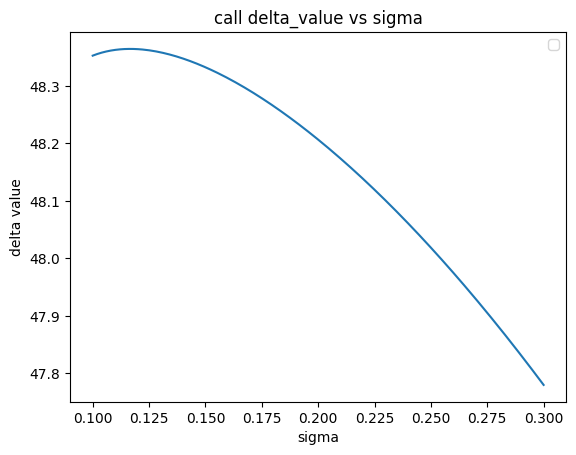

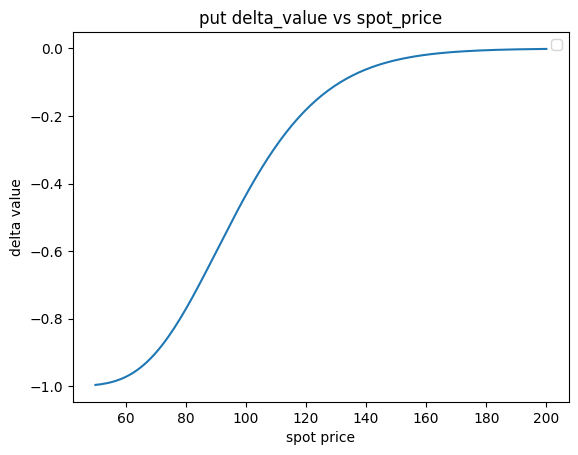

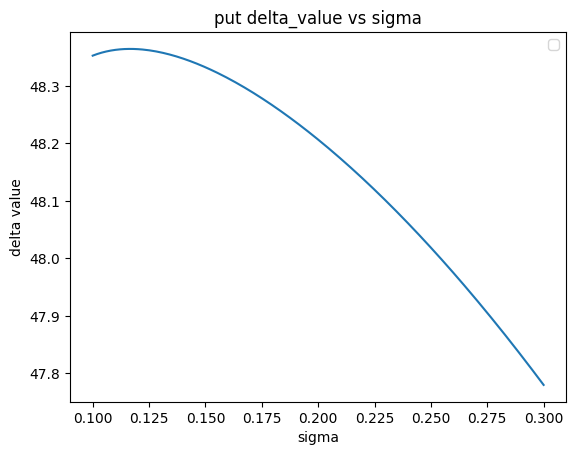

In [11]:
def black_scholes_value(S0, r, T, sigma, K, option_type):
  d2 = ((np.log(K/S0) - (r - sigma ** 2 / 2) * T)) / (sigma * np.sqrt(T))
  d1 = d2 - sigma * np.sqrt(T)
  import scipy.stats as stats
  if option_type == "call":
    return S0 * stats.norm.cdf(-d1) - K * np.exp(-r * T) * stats.norm.cdf(-d2)
  else:
    return K * np.exp(-r * T) * stats.norm.cdf(d2) - S0 * stats.norm.cdf(d1)

def plot_delta_value_vs_spot_prices (spot_prices, r, T, sigma, K, option_type, dS=1e-4):
  delta_values = []
  for price in spot_prices:
    value = black_scholes_value(price, r, T, sigma, K, option_type)
    d_value = black_scholes_value(price + dS, r, T, sigma, K, option_type) - value
    delta_values.append(d_value / dS)
  plt.plot(spot_prices, delta_values)
  plt.xlabel("spot price")
  plt.ylabel("delta value")
  plt.title(f"{option_type} delta_value vs spot_price")
  plt.legend()
  plt.show()

def plot_delta_value_vs_sigma(S0, r, T, sigmas, K, option_type, dSigma = 1e-5):
  delta_values = []
  for sigma in sigmas:
    value = black_scholes_value(S0, r, T, sigma, K, option_type)
    d_value = black_scholes_value(S0, r, T, sigma + dSigma, K, option_type) - value
    delta_values.append(d_value / dSigma)
  plt.plot(sigmas, delta_values)
  plt.xlabel("sigma")
  plt.ylabel("delta value")
  plt.title(f"{option_type} delta_value vs sigma")
  plt.legend()
  plt.show()

spot_prices = np.linspace(50, 200, 150)

sigmas = np.linspace(0.1, 0.3, 200)

option_type = "call"

plot_delta_value_vs_spot_prices(spot_prices, r, T, sigma, K, option_type)

plot_delta_value_vs_sigma(S0, r, T, sigmas, K, option_type)

option_type = "put"

plot_delta_value_vs_spot_prices(spot_prices, r, T, sigma, K, option_type)

plot_delta_value_vs_sigma(S0, r, T, sigmas, K, option_type)

# reset parameter to call
option_type = "call"

As the spot price increases, the slope of the call option value is increasing and always positive. It means that the spot price dominates the option value when the spot price is high. For the sigma plot, we can see that the slope of the call option value is always positive and has a peak at some point around 0.115. It means that the volatility can dominate the price around 0.115, and the call option value will increase as the volatility increases. And the put option follows the same trend with call option value. However, it change the positive slope into negative.

# Monte-Carlo Simulation

## Use Monte-Carlo method to price call and put options

In [12]:
def monte_carlo_option_pricing(S0, r, T, sigma, K, option_type, num_samples, seed):
  np.random.seed(seed)

  Z = np.random.standard_normal(num_samples)
  S_T = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z)

  if option_type == "call":
    payoffs = np.maximum(S_T - K, 0)
  else:
    payoffs = np.maximum(K - S_T, 0)

  option_price = np.exp(-r * T) * np.mean(payoffs)
  return option_price

num_samples = 2000

option_type = "call"

monte_carlo_option_price = monte_carlo_option_pricing(S0, r, T, sigma, K, option_type, num_samples, seed)
print(f"The monte carlo estimated price of the {option_type} option is: {monte_carlo_option_price:.2f}")

BTO = BinomialTreeOption(S0, r, T, sigma, N, K, option_type)
binomial_tree_option_price = BTO.price_option()
print(f"The binomial tree estimated price of the {option_type} option is: {binomial_tree_option_price:.2f}")

black_scholes_option_price = black_scholes_value(S0, r, T, sigma, K, option_type)
print(f"The black scholes estimated price of the {option_type} option is: {black_scholes_option_price:.2f}")

option_type = "put"

print("========================================= Change option type =========================================")

monte_carlo_option_price = monte_carlo_option_pricing(S0, r, T, sigma, K, option_type, num_samples, seed)
print(f"The monte carlo estimated price of the {option_type} option is: {monte_carlo_option_price:.2f}")

BTO = BinomialTreeOption(S0, r, T, sigma, N, K, option_type)
binomial_tree_option_price = BTO.price_option()
print(f"The binomial tree estimated price of the {option_type} option is: {binomial_tree_option_price:.2f}")

black_scholes_option_price = black_scholes_value(S0, r, T, sigma, K, option_type)
print(f"The black scholes estimated price of the {option_type} option is: {black_scholes_option_price:.2f}")

# reset parameter to call
option_type = "call"

The monte carlo estimated price of the call option is: 10.41
The binomial tree estimated price of the call option is: 10.09
The black scholes estimated price of the call option is: 10.21
========================================= Change option type =========================================
The monte carlo estimated price of the put option is: 9.18
The binomial tree estimated price of the put option is: 9.08
The black scholes estimated price of the put option is: 9.20


All estimated prices are close to each other.

## Suppose you have this portfolio:
 Long the underlying Stock and Short the Call.

 This strategy is called Coverred Call, can you use the Monte Carlo simulation to estimate 10 Day VaR for this
 portfolio? And plot the PnL distribution of your portfolio.

10 Day VaR: -5.113496946085886


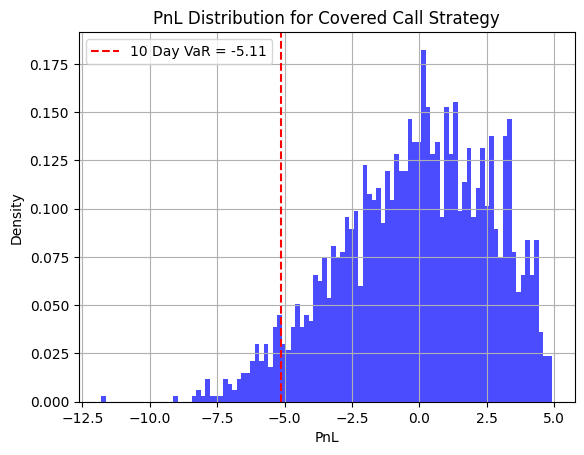

In [29]:
T = 10 / 365.2524
option_type = "call"

stock_prices = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.standard_normal(num_samples))
PnL = []
option_price = monte_carlo_option_pricing(S0, r, T, sigma, K, option_type, num_samples, seed)
for price in stock_prices:
  final_option_price = monte_carlo_option_pricing(price, r, T, sigma, K, option_type, num_samples, seed)
  PnL.append(price - S0 + option_price - final_option_price)

VaR_10d = np.percentile(PnL, 5)

print(f"10 Day VaR: {VaR_10d}")

plt.hist(PnL, bins=100, density=True, alpha=0.7, color='blue')
plt.axvline(x=VaR_10d, color='red', linestyle='--', label=f'10 Day VaR = {VaR_10d:.2f}')
plt.title("PnL Distribution for Covered Call Strategy")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Reset parameter
T = 1.5
option_type = "call"